In [1]:
%load_ext lab_black

import errno
import json
import os
import shutil
import stat
from copy import deepcopy
from datetime import datetime
from enum import Enum
from os import listdir
from os.path import isfile, join
from pathlib import Path
from random import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import tensorflow as tf
from keras import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.layers import *
from PIL import Image, ImageDraw
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tqdm.notebook import tqdm
from focal_loss import BinaryFocalLoss

# tf.debugging.set_log_device_placement(True)
plt.rcParams["figure.figsize"] = [40, 20]
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

Num GPUs Available:  1


In [2]:
from ArrayLoader import *
from augmentation import *
from CWDataset import *
from datautils import *

In [3]:
original_path = Path("data/CW/original")
generated_path = Path("data/CW/generated")

In [4]:
real_shape = (544, 1280, 3)
nn_shape = (544 // 4, 1280 // 4, 3)
augmented_samples = 6

In [5]:
dataset = CWDataset(generated_path)

Train 1136
Test  147
Vali  147


In [6]:
anchor_space = 8
anchors_count = (1 + real_shape[0] // anchor_space, 1 + real_shape[1] // anchor_space)

In [7]:
print((1 + real_shape[0] // anchor_space, 1 + real_shape[1] // anchor_space))

(69, 161)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.67it/s]


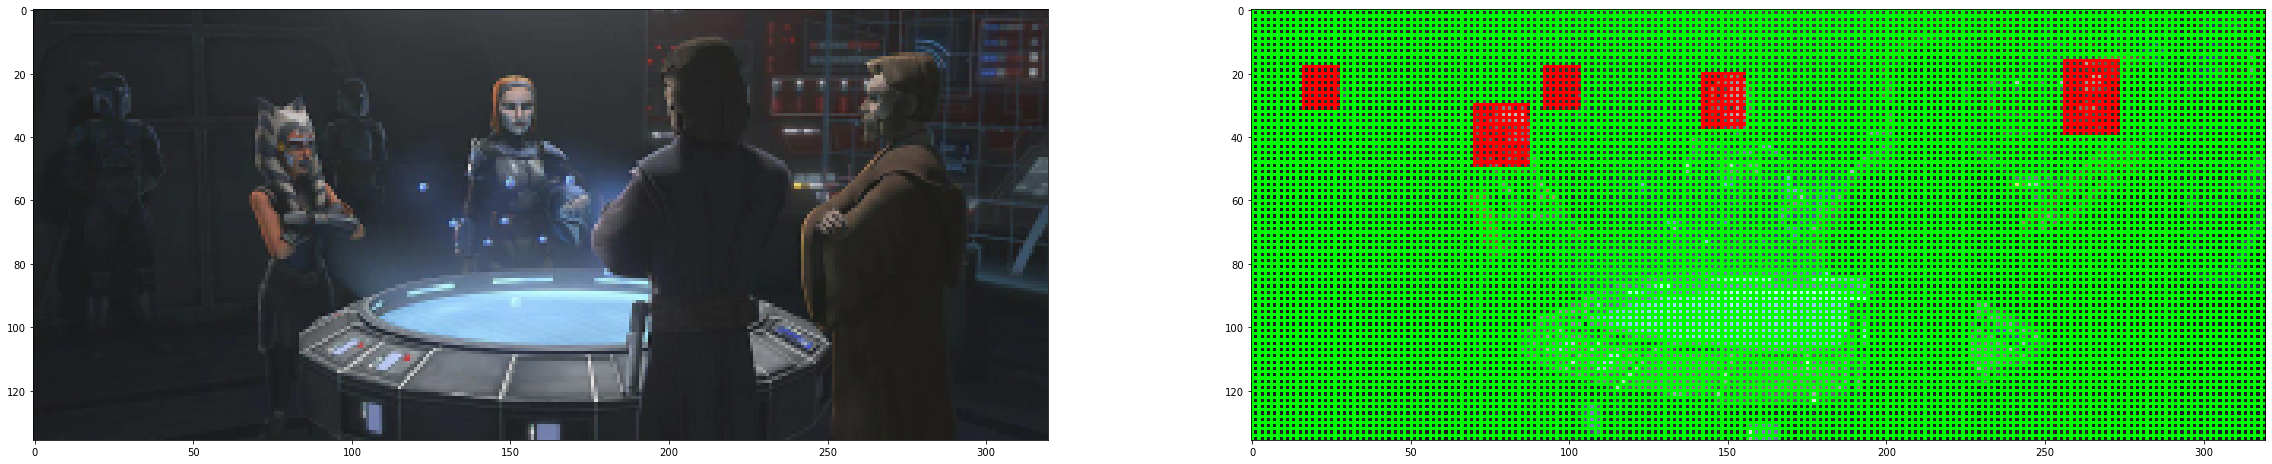

(69, 161) (69, 161)


In [8]:
def test_show_anchor():
    img, label = dataset.get_train(1, nn_shape[:2])
    show_label_anchors(img[0], label[0], anchor_space // 4)
    print(
        labels_to_markers(img[0].shape, label[0], anchor_space // 4).shape,
        anchors_count,
    )


test_show_anchor()

In [9]:
def build_anchor_RCNN(inp_shape, achor_counts):
    inp = Input(shape=inp_shape)
    headModel = Conv2D(32, (3, 3), activation="relu", padding="same")(inp)
    headModel = Conv2D(32, (3, 3), activation="relu", padding="same")(inp)
    headModel = MaxPooling2D((2, 2))(headModel)
    #     headModel = Conv2D(32, (3, 3), activation="relu")(headModel)
    #     headModel = MaxPooling2D((2, 2))(headModel)
    headModel = Conv2D(64, (3, 3), activation="relu", padding="same")(headModel)
    headModel = Conv2D(64, (3, 3), activation="relu", padding="same")(headModel)
    headModel = MaxPooling2D((2, 2))(headModel)

    headModel = Conv2D(128, (3, 3), activation="relu", padding="same")(headModel)
    headModel = Conv2D(128, (3, 3), activation="relu", padding="same")(headModel)
    headModel = MaxPooling2D((2, 2))(headModel)

    headModel = Conv2D(256, (3, 3), activation="relu", padding="same")(headModel)
    headModel = Conv2D(256, (3, 3), activation="relu", padding="same")(headModel)
    headModel = MaxPooling2D((2, 2))(headModel)

    headModel = Conv2D(512, (3, 3), activation="relu", padding="same")(headModel)
    headModel = Conv2D(512, (3, 3), activation="relu", padding="same")(headModel)
    headModel = MaxPooling2D((2, 2))(headModel)

    headModel = Flatten(name="flatten")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(achor_counts[0] * achor_counts[1], activation="sigmoid")(
        headModel
    )
    headModel = Reshape((achor_counts[0], achor_counts[1]))(headModel)
    model = Model(inputs=inp, outputs=headModel)
    model.compile(
        # loss="binary_crossentropy",
        loss=BinaryFocalLoss(gamma=3),  # ,
        # loss="mean_absolute_error",
        optimizer=Adam(lr=0.001),
        metrics=["accuracy"],
    )
    return model

In [10]:
def load_last_model():
    path = Path("model/anchor/")
    model = list(path.glob("*"))[-1]
    print("Loading model", model)
    model = tf.keras.models.load_model(str(model))
    return model

In [11]:
def train_anchor_model():
    anchor_model = build_anchor_RCNN(nn_shape, anchors_count)
    # anchor_model = load_last_model()

    print(anchor_model.summary())
    X, Y = prepare_anchor_dataset(
        *dataset.get_train(5000, shape=nn_shape[:2]), nn_shape[:2], anchor_space // 4
    )
    X_val, Y_val = prepare_anchor_dataset(
        *dataset.get_validation(5000, shape=nn_shape[:2]),
        nn_shape[:2],
        anchor_space // 4
    )

    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20, monitor="val_loss"),
        #         tf.keras.callbacks.ModelCheckpoint(
        #             filepath="model/anchor/model.{epoch:02d}-{val_loss:.2f}.h5"
        #         ),
        tf.keras.callbacks.TensorBoard(log_dir="./logs"),
    ]
    with tf.device("/GPU:0"):
        anchor_model.fit(
            X,
            Y,
            epochs=500,
            validation_data=(X_val, Y_val),
            callbacks=my_callbacks,
        )
    dt_string = datetime.now().strftime("model/anchor/%d-%m-%Y %H-%M-%S")
    print("Saved " + dt_string)
    anchor_model.save(dt_string)
    return anchor_model

In [ ]:
anchor_model = train_anchor_model()

# anchor_model = load_last_model()

In [ ]:
def anchor_model_on_data(arrays, labels, limit=10):
    small, _ = prepare_dataset(arrays, labels, nn_shape[:2])

    for i, (array, label) in enumerate(zip(arrays, labels)):
        if i >= limit:
            break
        predict = anchor_model.predict(small[i : i + 1])[0]
        #         print(predict.shape)
        #         print(predict.shape[0] * anchor_space, predict.shape[1] * anchor_space)
        #         print(array.shape)
        print(predict.max())
        show_anchors(
            array,
            anchor_space,
            labels_to_markers(array.shape, label, anchor_space),
            predict,
        )
        print(anchors_to_labels(predict, anchor_space, 0.4))
        plot_images(
            (array,),
            1,
            (label,),
            (anchors_to_labels(predict, anchor_space, 0.4),),
        )

In [ ]:
anchor_model_on_data(*dataset.get_train(1))

In [ ]:
anchor_model_on_data(*dataset.get_test(5), 20)

In [ ]:
def calculate_iou_levels(arrays, labels):
    X, _ = prepare_dataset(arrays, labels, nn_shape[:2])
    Y_real = labels
    predictions = anchor_model.predict(X)
    Y_pred = []
    for pred in tqdm(predictions):
        Y_pred.append(anchors_to_labels(pred, anchor_space, 0.4))

    for iou in range(1, 11):
        print(iou / 10.0, accuracy(Y_real, Y_pred, iou / 10.0))

In [ ]:
calculate_iou_levels(*dataset.get_train(5000))

In [ ]:
calculate_iou_levels(*dataset.get_test(5000))

In [ ]:
calculate_iou_levels(*dataset.get_validation(5000))

In [ ]:
create_video(
    model=anchor_model,
    source="data/CW/Ahsoka.mp4",
    result="data/CW/Ahsoka_labeled.mp4",
    dataset_transaformer=lambda arr: prepare_dataset(
        arr, ((),) * len(arr), nn_shape[:2]
    )[0],
    result_transformer=lambda pred: anchors_to_labels(pred, anchor_space, 0.5),
    start_pos=25 * 60 + 600,
    total_count=500,
    fps=10,
)

In [ ]:
# from IPython.display import Video

# Video("data/CW/Maul.mp4")
# Video("data/CW/labeled.mp4")